In [1]:
%matplotlib inline
import networkx as nx

In [92]:
from importlib import reload
import autodepgraph.graph_v2 as g
reload(g)
from autodepgraph.graph_v2 import AutoDepGraph_DAG

In [20]:
MyDag = AutoDepGraph_DAG(name='MyDAG')#, cfg_plot_mode='matplotlib')

In [21]:
cal_True_delayed=  'autodepgraph.node_functions.calibration_functions.test_calibration_True_delayed'
MyDag.add_node('A', calibrate_function=cal_True_delayed)
MyDag.add_node('B', calibrate_function=cal_True_delayed)
MyDag.add_node('C', calibrate_function=cal_True_delayed)
MyDag.add_node('D', calibrate_function=cal_True_delayed)
MyDag.add_node('E', calibrate_function=cal_True_delayed)
MyDag.add_node('F', calibrate_function=cal_True_delayed)

In [22]:
MyDag.nodes['A']

{'calibrate_function': 'autodepgraph.node_functions.calibration_functions.test_calibration_True_delayed',
 'check_function': 'autodepgraph.node_functions.check_functions.return_fixed_value',
 'last_update': datetime.datetime(2018, 3, 14, 22, 31, 29, 44106),
 'state': 'unknown',
 'timeout': inf,
 'tolerance': 0}

In [23]:
MyDag.add_edge("A", 'B')
MyDag.add_edge("A", 'C')
MyDag.add_edge("B", 'C')
MyDag.add_edge("B", 'C')
MyDag.add_edge("D", 'C')
MyDag.add_edge("F", 'E')


In [24]:
MyDag.set_all_node_states('needs calibration')
MyDag.nodes()['C']['state'] = ['unknown']
MyDag.maintain_node('A')

Maintaining node "A".
Maintaining node "B".
Maintaining node "C".
	Checking node C.
	Node C needs calibration.
	Calibrating node C.
	Calibration of node C successful.
	Calibrating node B.
	Calibration of node B successful.
	Calibrating node A.
	Calibration of node A successful.


'good'

In [25]:
MyDag.nodes()['C']['state'] = 'unknown'

In [26]:
for n in MyDag.nodes(True):
    print(n[1]['state'])

good
good
unknown
needs calibration
needs calibration
needs calibration


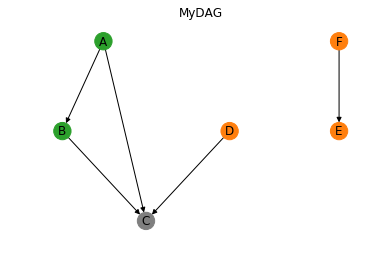

In [27]:
MyDag.update_monitor_mpl()

In [28]:
win = MyDag.draw_pg()

In [29]:
nx.readwrite.write_yaml(MyDag, MyDag.name+'.yaml')

In [30]:
newMyDag = nx.readwrite.read_yaml(MyDag.name+'.yaml')

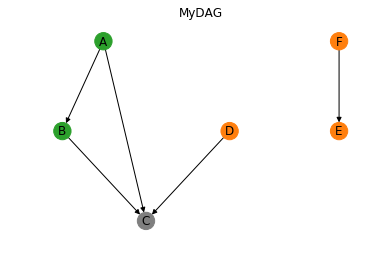

In [31]:
newMyDag.draw_mpl()

In [32]:

nG = nx.compose(MyDag, newMyDag)

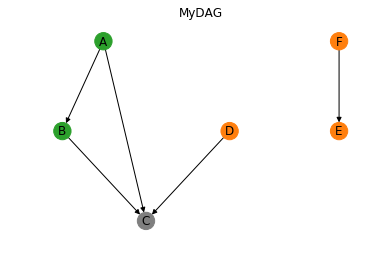

In [33]:
nG.draw_mpl()

In [36]:
nG.nodes()

NodeView(('A', 'B', 'C', 'D', 'E', 'F'))

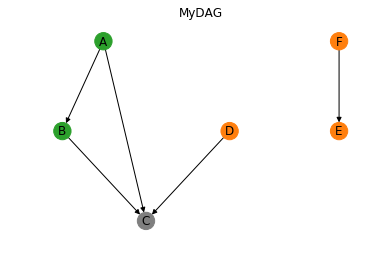

In [35]:


MyDag.draw_mpl()


## A mock qubit tuneup 

In [104]:
import unittest
import numpy as np
import os
import pycqed as pq
import time

import pycqed.analysis.analysis_toolbox as a_tools

import pycqed.instrument_drivers.virtual_instruments.virtual_AWG8 as v8
import pycqed.instrument_drivers.virtual_instruments.virtual_SignalHound as sh
import pycqed.instrument_drivers.virtual_instruments.virtual_MW_source as vmw
from pycqed.instrument_drivers.meta_instrument.LutMans import mw_lutman as mwl
from pycqed.measurement.waveform_control_CC import waveform as wf
import pycqed.instrument_drivers.meta_instrument.qubit_objects.CCL_Transmon as ct
from pycqed.measurement import measurement_control
from qcodes import station

from pycqed.instrument_drivers.physical_instruments.ZurichInstruments.dummy_UHFQC import dummy_UHFQC

from pycqed.instrument_drivers.physical_instruments.QuTech_Duplexer import Dummy_Duplexer


from pycqed.instrument_drivers.meta_instrument.qubit_objects.QuDev_transmon import QuDev_transmon
from pycqed.instrument_drivers.meta_instrument.qubit_objects.Tektronix_driven_transmon import Tektronix_driven_transmon
from pycqed.instrument_drivers.meta_instrument.qubit_objects.CC_transmon import CBox_v3_driven_transmon, QWG_driven_transmon
from pycqed.instrument_drivers.physical_instruments.QuTech_CCL import dummy_CCL
from pycqed.instrument_drivers.physical_instruments.QuTech_VSM_Module import Dummy_QuTechVSMModule
from pycqed.instrument_drivers.meta_instrument.LutMans.ro_lutman import UHFQC_RO_LutMan

Dummy_VSM_not_fixed = False

try:
    import openql
    openql_import_fail = False
except:
    openql_import_fail = True


station = station.Station()
q0 = ct.CCLight_Transmon('q0')
q1 = ct.CCLight_Transmon('q1')
q2 = ct.CCLight_Transmon('q2')

MW1 = vmw.VirtualMWsource('MW1')
MW2 = vmw.VirtualMWsource('MW2')
MW3 = vmw.VirtualMWsource('MW3')
SH = sh.virtual_SignalHound_USB_SA124B('SH')
UHFQC = dummy_UHFQC('UHFQC')

CCL = dummy_CCL('CCL')
# VSM = Dummy_Duplexer('VSM')
VSM = Dummy_QuTechVSMModule('VSM')

MC = measurement_control.MeasurementControl(
            'MC', live_plot_enabled=False, verbose=False)
MC.station = station
station.add_component(MC)

# Required to set it to the testing datadir
test_datadir = os.path.join(pq.__path__[0], 'tests', 'test_output')
MC.datadir(test_datadir)
a_tools.datadir = MC.datadir()

AWG = v8.VirtualAWG8('DummyAWG8')
AWG8_VSM_MW_LutMan = mwl.AWG8_VSM_MW_LutMan('MW_LutMan_VSM')
AWG8_VSM_MW_LutMan.AWG(AWG.name)
AWG8_VSM_MW_LutMan.channel_GI(1)
AWG8_VSM_MW_LutMan.channel_GQ(2)
AWG8_VSM_MW_LutMan.channel_DI(3)
AWG8_VSM_MW_LutMan.channel_DQ(4)
AWG8_VSM_MW_LutMan.mw_modulation(100e6)
AWG8_VSM_MW_LutMan.sampling_rate(2.4e9)

ro_lutman = UHFQC_RO_LutMan('RO_lutman', num_res=5)
ro_lutman.AWG(UHFQC.name)

# Assign instruments
for qi in [q0, q1, q2]:
    qi.instr_LutMan_MW(AWG8_VSM_MW_LutMan.name)
    qi.instr_LO_ro(MW1.name)
    qi.instr_LO_mw(MW2.name)
    qi.instr_spec_source(MW3.name)

    qi.instr_acquisition(UHFQC.name)
    qi.instr_VSM(VSM.name)
    qi.instr_CC(CCL.name)
    qi.instr_LutMan_RO(ro_lutman.name)
    qi.instr_MC(MC.name)

    qi.instr_SH(SH.name)

    config_fn = os.path.join(pq.__path__[0], 'tests', 'test_cfg_CCL.json')
    qi.cfg_openql_platform_fn(config_fn)

            # Setting some "random" initial parameters
    qi.ro_freq(5.43e9)
    qi.ro_freq_mod(200e6)

    qi.freq_qubit(4.56e9)
    qi.freq_max(4.62e9)

    qi.mw_freq_mod(-100e6)
    qi.mw_awg_ch(1)
    qi.cfg_qubit_nr(0)

    qi.mw_vsm_delay(15)

    qi.mw_mixer_offs_GI(.1)
    qi.mw_mixer_offs_GQ(.2)
    qi.mw_mixer_offs_DI(.3)
    qi.mw_mixer_offs_DQ(.4)

Connected to: <CCLight_Transmon: q0> in 0.01 s
Connected to: <CCLight_Transmon: q1> in 0.01 s
Connected to: <CCLight_Transmon: q2> in 0.01 s


KeyError: 'Another instrument has the name: MW1'

In [41]:
MC.datadir()

'/Users/Adriaan/GitHubRepos/DiCarloLab_Repositories/PycQED_py3/pycqed/tests/test_output'

In [40]:
CCL_qubit.measure_allxy()

0.98967966964990006

In [43]:
self=CCL_qubit

In [51]:
self.find_frequency()

Peak Finder: Optimal num_sigma_threshold after optimization is  14


4584000000.0

In [50]:
self.find_resonator_frequency()

ValueError: Specify "freq_res" to generate a freq span

In [ ]:
self.calibrate_

In [96]:
reload(g)

<module 'autodepgraph.graph_v2' from '/Users/Adriaan/GitHubRepos/DiCarloLab_Repositories/AutoDepGraph/autodepgraph/graph_v2.py'>

In [97]:
def create_dep_graph(self): 
    DAG  = g.AutoDepGraph_DAG(name = self.name+' DAG')
    
    DAG.add_node(self.name+' resonator frequency', calibrate_function=self.name +'.find_resonator')
    DAG.add_node(self.name+' frequency coarse', calibrate_function=self.name +'.find_frequency')
    DAG.add_edge( self.name+' frequency coarse', self.name+' resonator frequency')
    
    DAG.add_node(self.name+' mixer offsets drive', calibrate_function=self.name +'.calibrate_mixer_offsets_drive')
    DAG.add_node(self.name+' mixer skewness drive', calibrate_function=self.name +'.calibrate_mixer_skewness_drive')
    DAG.add_node(self.name+' mixer offsets readout', calibrate_function=self.name +'.calibrate_mixer_offsets_RO')
    
    DAG.add_node(self.name  + ' pulse amplitude coarse', calibrate_function=self.name +'.measure_rabi')
    DAG.add_edge( self.name + ' pulse amplitude coarse', self.name+' frequency coarse')
    DAG.add_edge( self.name + ' pulse amplitude coarse', self.name+' mixer offsets drive')
    DAG.add_edge( self.name + ' pulse amplitude coarse', self.name+' mixer skewness drive')
    DAG.add_edge( self.name + ' pulse amplitude coarse', self.name+' mixer offsets readout')
    
    
    
    DAG.add_node(self.name+' T1', calibrate_function=self.name +'.measure_T1')
    DAG.add_node(self.name+' T2-echo', calibrate_function=self.name +'.measure_echo')
    DAG.add_node(self.name+' T2-star', calibrate_function=self.name +'.measure_ramsey')
    DAG.add_edge( self.name + ' T1', self.name+' pulse amplitude coarse')
    DAG.add_edge( self.name + ' T2-echo', self.name+' pulse amplitude coarse')
    DAG.add_edge( self.name + ' T2-star', self.name+' pulse amplitude coarse')
    
    DAG.add_node(self.name+' frequency fine', calibrate_function=self.name +'.calibrate_frequency_ramsey')     
    DAG.add_edge( self.name + ' frequency fine', self.name+' pulse amplitude coarse')
    
    DAG.add_node(self.name  + ' pulse amplitude med', calibrate_function=self.name +'.measure_rabi')
    DAG.add_edge( self.name + ' pulse amplitude med', self.name+' frequency fine')
    
    DAG.add_node(self.name +' optimal weights', calibrate_function=self.name+'.calibrate_optimal_weights')
    DAG.add_edge( self.name + ' optimal weights', self.name+' pulse amplitude med')
    
    DAG.add_node(self.name+' gates restless', calibrate_function=self.name +'.calibrate_mw_gates_restless')
    DAG.add_edge( self.name + ' gates restless', self.name+' optimal weights')

    # easy to implement a check
    DAG.add_node(self.name+' frequency fine', calibrate_function=self.name +'.calibrate_frequency_ramsey')     
    return DAG


DAG =create_dep_graph(CCL_qubit)
DAG.draw_svg()

In [98]:
DAG.cfg_plot_mode = 'pyqtgraph'

In [99]:
DAG.maintain_node('CCL_qubit gates restless')

Maintaining node "CCL_qubit gates restless".
	Checking node CCL_qubit gates restless.
too many values to unpack (expected 2)
	Node CCL_qubit gates restless needs calibration.
	Calibrating node CCL_qubit gates restless.
hello!
(3_w,7)-aCMA-ES (mu_w=2.3,w_1=58%) in dimension 3 (seed=126716, Wed Mar 14 23:10:04 2018)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      7 -1.544935821472761e-04 1.0e+00 1.00e+00  2e+03  9e+05 0:00.0
    2     14 -2.068881175514131e-04 1.4e+00 8.64e-01  1e+03  8e+05 0:00.0
    3     21 -1.721315388874445e-04 1.6e+00 7.12e-01  1e+03  6e+05 0:00.1
  100    700 -1.588175759817871e-04 1.0e+01 2.19e-01  9e+01  4e+04 0:01.8
  200   1400 -1.625322225093114e-04 3.6e+02 4.81e-01  2e+02  1e+05 0:03.8
  300   2100 -1.393782909344945e-04 8.0e+02 7.03e-02  4e+00  2e+03 0:05.7
  400   2800 -1.729500735615970e-04 5.2e+02 4.95e-03  7e-03  3e+00 0:07.2
  500   3500 -1.560364614281228e-04 2.7e+03 1.40e-03  3e-04  1e-01 0:08.7
  510   3570 -1.5788

'bad'

In [101]:
DAG.maintain_node('CCL_qubit frequency fine')

Maintaining node "CCL_qubit frequency fine".
	Checking node CCL_qubit frequency fine.
too many values to unpack (expected 2)
	Node CCL_qubit frequency fine needs calibration.
	Calibrating node CCL_qubit frequency fine.
hello!


Measured detuning:1.52e+07
Setting freq to: 4.569210462e+09, 



Measured detuning:1.34e+07
Setting freq to: 4.555777153e+09, 



Measured detuning:7.78e+05
Setting freq to: 4.554999493e+09, 



Measured detuning:1.78e+06
Setting freq to: 4.553221037e+09, 



Measured detuning:7.20e+04
Setting freq to: 4.553149036e+09, 



ValueError: ('0.0020399998500887288 is invalid: must be between 0 and 0.0002 inclusive; Parameter: CCL_qubit.T2_star', 'setting CCL_qubit_T2_star to 0.002039999850088729')